In [6]:
%matplotlib inline
import gtsam
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Simulator:
    def __init__(self, seed=0):
        self.sigma_x = 0.01
        self.sigma_y = 0.01
        self.sigma_theta = 0.005
        self.sigma_bearing = 0.005
        self.sigma_range = 0.01

        self.max_range = 5.0
        self.max_bearing = np.pi * 2.0 / 3.0
        self.seed = seed
        self.random_state = np.random.RandomState(self.seed)

        # Define env and traj here
        self.env = {}  # l -> gtsam.Point2
        self.traj = []  # gtsam.Pose2

    def reset(self):
        self.random_state = np.random.RandomState(self.seed)

    def random_map(self, size, limit):
        """
        size: num of landmarks
        limit: l, r, b, t
        """
        self.env = {}
        l, r, b, t = limit
        for i in range(size):
            x = self.random_state.uniform(l, r)
            y = self.random_state.uniform(b, t)
            self.env[i] = gtsam.Point2(x, y)

    def step(self):
        """
        return:
          odom: odom between two poses (initial pose is returned for the first step)
          obs: dict of (landmark -> (bearing, range))
        """
        for i in range(len(self.traj)):
            if i == 0:
                odom = gtsam.Pose2()
            else:
                odom = self.traj[i - 1].between(self.traj[i])
            nx = self.random_state.normal(0.0, self.sigma_x)
            ny = self.random_state.normal(0.0, self.sigma_y)
            nt = self.random_state.normal(0.0, self.sigma_theta)
            odom = odom.compose(gtsam.Pose2(nx, ny, nt))

            obs = {}
            for l, point in self.env.items():
                b = self.traj[i].bearing(point).theta()
                r = self.traj[i].range(point)
                b += self.random_state.normal(0.0, self.sigma_bearing)
                r += self.random_state.normal(0.0, self.sigma_range)

                if 0 < r < self.max_range and abs(b) < self.max_bearing:
                    obs[l] = b, r

            if i == 0:
                yield self.traj[0].compose(odom), obs
            else:
                yield odom, obs

In [8]:
def X(x):
    return gtsam.symbol('x', x)


def L(l):
    return gtsam.symbol('l', l)


def slam(sim):
    isam2 = gtsam.ISAM2()
    graph = gtsam.NonlinearFactorGraph()
    values = gtsam.Values()

    observed = set()
    for x, (odom, obs) in enumerate(sim.step()):
        if x == 0:
            prior_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([sim.sigma_x, sim.sigma_y, sim.sigma_theta]))
            prior_factor = gtsam.PriorFactorPose2(X(0), odom, prior_model)
            graph.add(prior_factor)
            values.insert(X(0), odom)
        else:
            odom_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([sim.sigma_x, sim.sigma_y, sim.sigma_theta]))
            odom_factor = gtsam.BetweenFactorPose2(X(x - 1), X(x), odom, odom_model)
            graph.add(odom_factor)
            pose0 = isam2.calculateEstimatePose2(X(x - 1))
            values.insert(X(x), pose0.compose(odom))

        isam2.update(graph, values)
        graph.resize(0)
        values.clear()
        estimate = isam2.calculateEstimate()

        # perfect data association
        for l_true, br in obs.items():
            br_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([sim.sigma_bearing, sim.sigma_range]))
            br_factor = gtsam.BearingRangeFactor2D(X(x), L(l_true), gtsam.Rot2(br[0]), br[1], br_model)
            graph.add(br_factor)
            if l_true not in observed:
                pose1 = isam2.calculateEstimatePose2(X(x))
                point = gtsam.Point2(br[1] * np.cos(br[0]), br[1] * np.sin(br[0]))
                values.insert(L(l_true), pose1.transformFrom(point))
                observed.add(l_true)
    
        isam2.update(graph, values)
        graph.resize(0)
        values.clear()

    traj_est = [isam2.calculateEstimatePose2(X(x)) for x in range(len(sim.traj))]
    traj_est = np.array([(p.x(), p.y(), p.theta()) for p in traj_est])
    landmark_est = np.array([isam2.calculateEstimatePoint2(L(l)) for l in observed])
    return [[traj_est, landmark_est]]

def plot_sim(ax, sim):
    traj = np.array([(p.x(), p.y(), p.theta()) for p in sim.traj])
    landmark = np.array([p for p in sim.env.values()])
    p1 = ax.scatter(landmark[:, 0], landmark[:, 1], marker='x', lw=2, s=100)
    (p2, ) = ax.plot(traj[:, 0], traj[:, 1], 'k-', lw=2)
    ax.set_aspect('equal')
    return p1, p2


def plot_est(ax, result):
    for i, (traj_est, landmark_est) in enumerate(result):
        if i == 0:
            p1 = ax.scatter(landmark_est[:, 0], landmark_est[:, 1], marker='+', lw=2, alpha=0.5)
            alpha = 1.0
        else:
            alpha = 0.1
        (p2, ) = ax.plot(traj_est[:, 0], traj_est[:, 1], 'g-', lw=2, alpha=alpha)
    ax.set_aspect('equal')
    return p1, p2

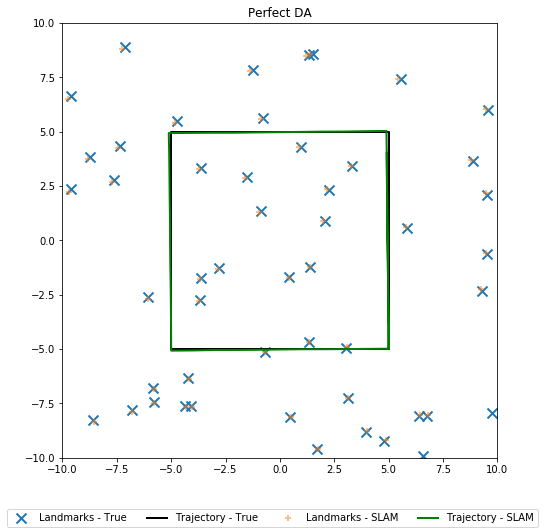

In [9]:
# Design a simulator
sim = Simulator()
sim.random_map(50, (-10, 10, -10, 10))
pose = gtsam.Pose2(5, -5, np.pi / 2.0)
for i in range(50):
    sim.traj.append(pose)
    if i % 10 == 0 and i > 0:
        u = 0.0, 1.0, np.pi / 2.0
    else:
        u = 1.0, 0.0, 0.0
    pose = pose.compose(gtsam.Pose2(*u))

fig, ax = plt.subplots(figsize=(8, 8))

# Perfect DA
sim.reset()
result = slam(sim)
p1, p2 = plot_sim(ax, sim)
p3, p4 = plot_est(ax, result)
ax.set_title('Perfect DA')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
fig.legend((p1, p2, p3, p4), ('Landmarks - True', 'Trajectory - True',
                              'Landmarks - SLAM', 'Trajectory - SLAM'),
            'lower center', ncol=4, fontsize='medium')
plt.show()